### GPU setup

In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow[and-cuda]

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (645.0 MB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf

2025-07-19 13:02:57.647856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 13:02:57.668210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752948177.681260   43738 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752948177.685012   43738 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752948177.694933   43738 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA:  True


In [4]:
import subprocess
import sys

# Check NVIDIA driver
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print("NVIDIA-SMI output:")
    print(result.stdout)
except FileNotFoundError:
    print("nvidia-smi not found. NVIDIA drivers may not be installed.")


NVIDIA-SMI output:
Sat Jul 19 13:03:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.65                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   62C    P8              6W /   40W |    1882MiB /   4096MiB |     28%      Default |
|                                         |                        |                  N/A |
+----------------------------

--- 

## Loading data into tensorflow for training

In [15]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt

In [24]:
images_path = 'raw_data/archive/train'

img_height = 48
img_width = 48

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=420,
    image_size=(img_height, img_width),
    batch_size=32,
    color_mode='grayscale'
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [25]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=420,
    image_size=(img_height, img_width),
    batch_size=32,
    color_mode='grayscale'
)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [26]:
train_dataset.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#### HEADS UP!
We're going to discard the disgust feeling due to the fact that there is not enough images to be fairly trained against the others sentiments.

2025-07-19 14:13:37.390015: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


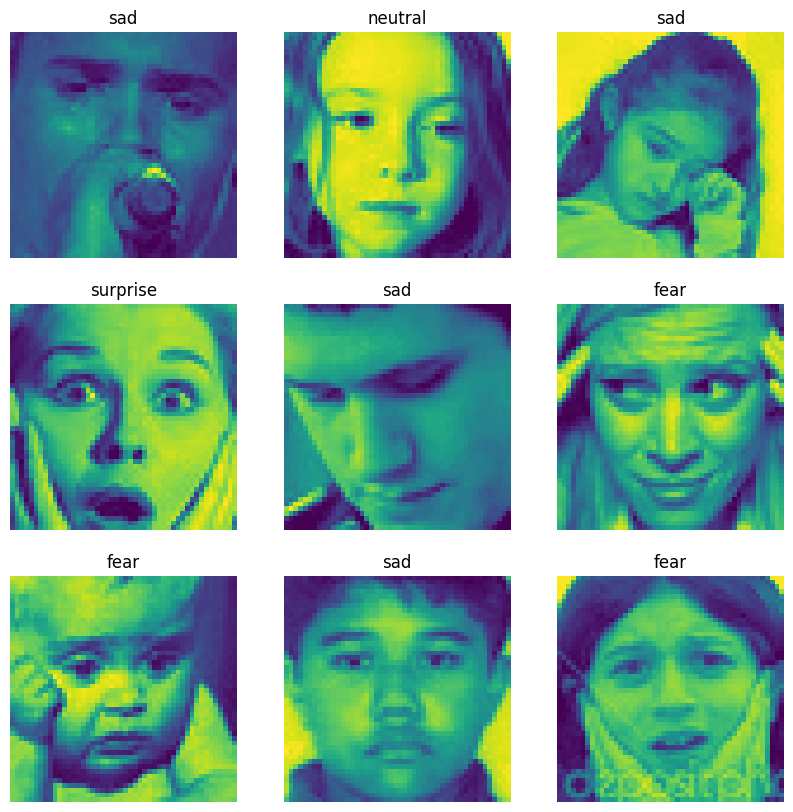

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis("off")

In [30]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    break

(32, 48, 48, 1)


---
## Starting off with the Convulutional Layers

In [58]:
# lets remove all the disgust labeled imagess
train_dataset.class_names

def filter_disgust(image, label):
    return tf.reduce_all(tf.not_equal(label, 1)) # 1 is the index for disgust in the class names

train_dataset_filtered = train_dataset.filter(filter_disgust)
validation_dataset_filtered = validation_dataset.filter(filter_disgust)


print('===Filtered datasets===')


remaining_labels = set()
for images, labels in train_dataset_filtered.take(5):
    remaining_labels.update(labels.numpy())


print("\nRemaining classes:")
for label_idx in remaining_labels:
    print(f"Label {label_idx}: {train_dataset.class_names[label_idx]}")

===Filtered datasets===

Remaining classes:
Label 0: angry
Label 2: fear
Label 3: happy
Label 4: neutral
Label 5: sad
Label 6: surprise


In [60]:
# Checking what are the types of the datasets
print("Type of train_dataset_filtered and train_dataset:")
print(type(train_dataset_filtered) == type(train_dataset))
print(type(train_dataset_filtered))
print(type(train_dataset))

Type of train_dataset_filtered and train_dataset:
False
<class 'tensorflow.python.data.ops.filter_op._FilterDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [63]:
for images, labels in train_dataset_filtered:
    conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_height, img_width, 1))
    fmaps = conv_layer(images)  

/home/salos/.pyenv/versions/3.12.9/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


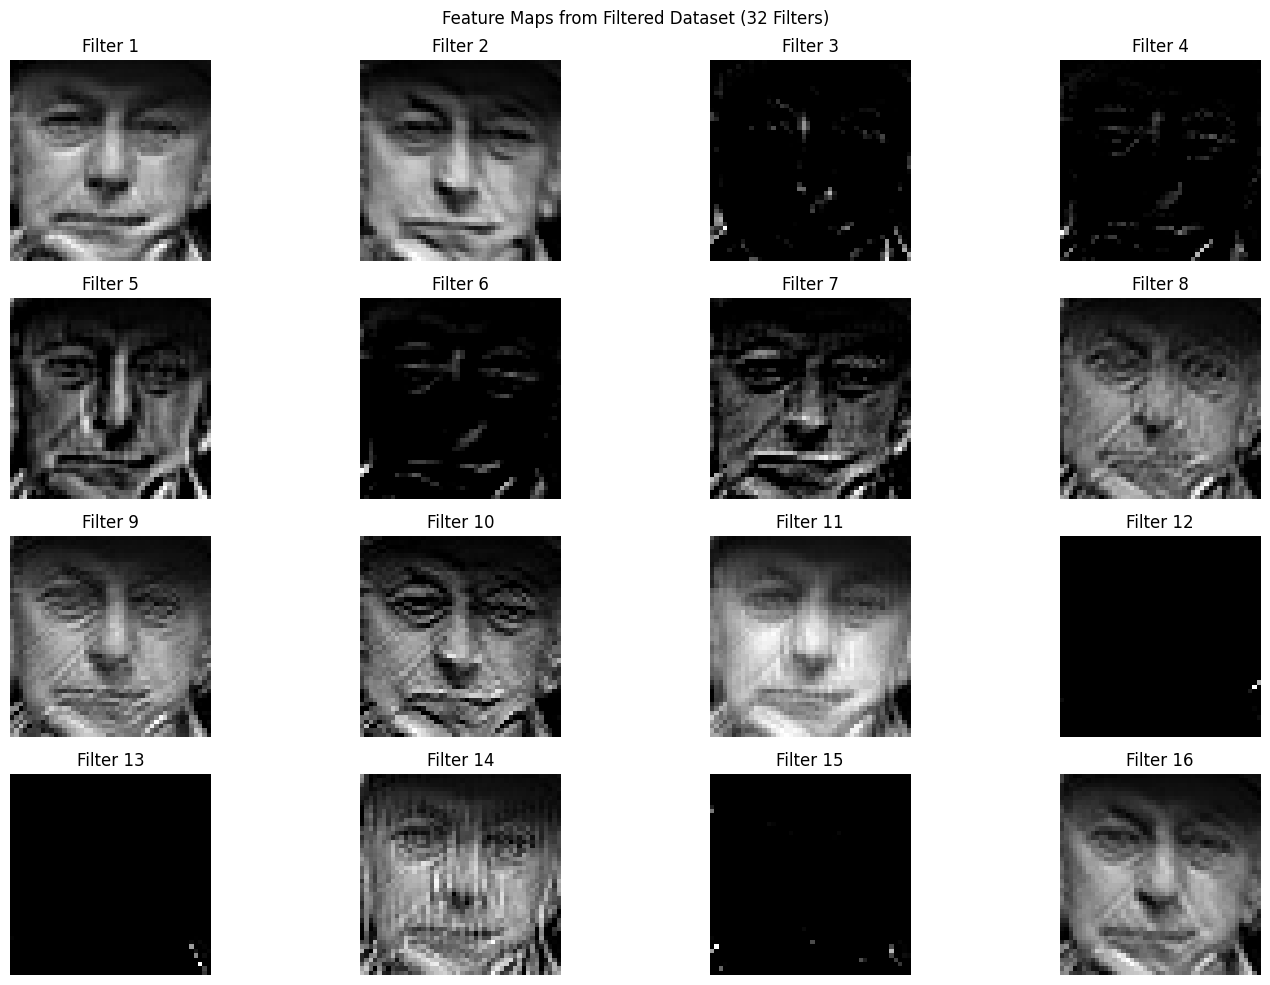

In [68]:
plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fmaps[4, :, :, i], cmap='gray')
    plt.title(f'Filter {i+1}')
    plt.axis('off')
plt.suptitle('Feature Maps from Filtered Dataset (32 Filters)')
plt.tight_layout()
plt.show()

In [ ]:
# Common CNN architecture for grayscale emotion recognition
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # ... rest of model
])

In [69]:
kernel, biases = conv_layer.get_weights()
kernel.shape, biases.shape

((3, 3, 1, 32), (32,))

In [70]:
for images, labels in train_dataset_filtered.take(1):
    print(images.shape)
    break

(32, 48, 48, 1)
